# Importing Libraries

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

import torch.optim as optim

import os

from PIL import Image, ImageOps

import random

#import any other library you need below this line
import math

#Loading data

Upload the data in zip format to Colab. Then run the cell below.

In [ ]:
!unzip data.zip

#Defining the Dataset Class

In [4]:
class Cell_data(Dataset):
    def __init__(self, data_dir, size, train = True, train_test_split = 0.8, augment_data = True):
        ##########################inputs##################################
        #data_dir(string) - directory of the data#########################
        #size(int) - size of the images you want to use###################
        #train(boolean) - train data or test data#########################
        #train_test_split(float) - the portion of the data for training###
        #augment_data(boolean) - use data augmentation or not#############
        super(Cell_data, self).__init__()

        #initialize the data class
        self.augment_data = augment_data
        self.size = size

        # get scans and labels path
        self.scan_dir = os.path.join(data_dir, 'scans')
        self.label_dir = os.path.join(data_dir, 'labels')
        # get file name list
        self.scan_files = os.listdir(self.scan_dir)

        # shuffle the scan_dir
        random.shuffle(self.scan_files)

        # find train-test index bound based on parameters:
        train_test_bound = int(train_test_split*len(self.scan_files))
        start_idx, end_idx = (0, train_test_bound) if train else (train_test_bound, len(self.scan_files))
        # end_idx = (len(self.scan_files) - train_test_bound) if train else 
        
        # form data and label data_files sets
        self.image = [os.path.join(self.scan_dir, file_name) for file_name in self.scan_files[start_idx:end_idx]]
        self.label = [os.path.join(self.label_dir, file_name) for file_name in self.scan_files[start_idx:end_idx]] 
        

    def __getitem__(self, idx):
        # load image and mask from index idx of your data
        image = Image.open(self.image[idx])
        label = Image.open(self.label[idx])
        
        # data augmentation part
        if self.augment_data:
            augment_mode = np.random.randint(0, 4)
            if augment_mode == 0:
            # flip image vertically
                image = image.transpose(Image.FLIP_LEFT_RIGHT)
                label = label.transpose(Image.FLIP_LEFT_RIGHT)
            elif augment_mode == 1:
            # flip image horizontally
                image = image.transpose(Image.FLIP_TOP_BOTTOM)
                label = label.transpose(Image.FLIP_TOP_BOTTOM)
            elif augment_mode == 2:
            # zoom image
                rand_zoom = np.random.randint(2, 6)
                w, h = image.size
                image = ImageOps.crop(image, (w if rand_zoom>=4 else h) // rand_zoom)
                image = image.resize((w, h))
                label = ImageOps.crop(label, (w if rand_zoom>=4 else h) // rand_zoom)
                label = label.resize((w, h))
            else:
            # rotate image
                image = image.transpose(Image.ROTATE_180)
                label = label.transpose(Image.ROTATE_180)

        #return image and mask in tensors
        transform_norm = transforms.Compose([
            transforms.Resize((self.size, self.size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5), (0.5)) # greyscale pic only contains single channel
        ])
        label_norm = transforms.Compose([
            transforms.Resize((self.size, self.size)),
            transforms.PILToTensor()
        ])
        image_tensor = transform_norm(image) # [1, 572, 572]
        label_tensor = label_norm(label) # [1, 572, 572]

        return (image_tensor, label_tensor)
        
        

    def __len__(self):
        return len(self.image)


#Define the Model
1. Define the Convolution blocks
2. Define the down path
3. Define the up path
4. combine the down and up path to get the final model

In [5]:
class twoConvBlock(nn.Module):
  def __init__(self, input_channel, output_channel):
    super(twoConvBlock, self).__init__()

    self.model = nn.Sequential (
        nn.Conv2d(input_channel, output_channel, 3),
        nn.ReLU(),
        nn.Conv2d(output_channel, output_channel, 3),
        nn.BatchNorm2d(output_channel),
        nn.ReLU()
    )

  def forward(self, x):
    return self.model(x)

class downStep(nn.Module):
  def __init__(self, input_channel, output_channel):
    super(downStep, self).__init__()

    self.down = nn.Sequential (
        nn.MaxPool2d(2, 2),
        twoConvBlock(input_channel, output_channel)
    )
    
  def forward(self, x):
    return self.down(x)

class upStep(nn.Module):
  def __init__(self, input_channel, output_channel):
    super(upStep, self).__init__()
    
    #initialize the up path
    self.up_conv = nn.ConvTranspose2d(input_channel, output_channel, 2, 2)
    self.conv_block = twoConvBlock(input_channel, output_channel)

  def forward(self, x, prev_x):
    # up-sample convolution
    x = self.up_conv(x)

    diff_h = (prev_x.shape[2] - x.shape[2])//2
    diff_w = (prev_x.shape[3] - x.shape[3])//2
    # making padding and concat
    h_start, h_end = diff_h, diff_h+x.shape[2]
    w_start, w_end = diff_w, diff_w+x.shape[3]
    prev_x = prev_x[:,:,h_start:h_end,w_start:w_end]
    x = torch.concat((prev_x, x), 1)
    # two-block convolution
    x = self.conv_block(x)
    return x

class UNet(nn.Module):
  def __init__(self):
    super(UNet, self).__init__()
    # max-pool
    self.down_stage1 = twoConvBlock(1, 64)
    self.down_stage2 = downStep(64, 128)
    self.down_stage3 = downStep(128, 256)
    self.down_stage4 = downStep(256, 512)
    self.down_1024 = downStep(512, 1024)
    # up-conv:
    self.up_stage1 = upStep(1024, 512)
    self.up_stage2 = upStep(512, 256)
    self.up_stage3 = upStep(256, 128)
    self.up_stage4 = upStep(128, 64)
    self.out_layer = nn.Conv2d(64, 2, 1) # 1 x 1 conv

  def forward(self, x):
    # max-pool:
    x1 = self.down_stage1(x) # twoConv(1,64) -> 64
    x2 = self.down_stage2(x1) # maxpool(64)+twoConv(64,128) -> 128
    x3 = self.down_stage3(x2) # maxpool(128)+twoConv(128,256) -> 256
    x4 = self.down_stage4(x3) # maxpool(256)+twoConv(256,512) -> 512
    x = self.down_1024(x4) # maxpool(512)+twoConv(512,1024) -> 1024

    # up-conv:
    x = self.up_stage1(x, x4) # 1024 -> 512
    x = self.up_stage2(x, x3) # 512 -> 256
    x = self.up_stage3(x, x2) # 256 -> 128
    x = self.up_stage4(x, x1) # 128 -> 64
    # last 2-block conv
    x = self.out_layer(x) # last 64 -> 2
    return x



#Training

In [15]:
#Paramteres

#learning rate
lr = 1e-3

#number of training epochs
epoch_n = 30

#input image-mask size
image_size = 572
#root directory of project
root_dir = os.getcwd()

#training batch size
batch_size = 4

#use checkpoint model for training
load = False

#use GPU for training
gpu = True

data_dir = os.path.join(root_dir, 'data/cells')

###### for train-test loss plot #######
train_loss = []
test_loss = []


trainset = Cell_data(data_dir = data_dir, size = image_size)
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle=True)

testset = Cell_data(data_dir = data_dir, size = image_size, train = False)
testloader = DataLoader(testset, batch_size = batch_size)

device = torch.device('cuda:0' if gpu else 'cpu')

model = UNet().to(device)

if load:
  print('loading model')
  model.load_state_dict(torch.load('checkpoint.pt'))

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.99, weight_decay=0.0005)

# model.train()
for e in range(epoch_n):
  epoch_loss = 0
  model.train()
  for i, data in enumerate(trainloader):
    image, label = data

    # image = image.unsqueeze(1).to(device)
    image = image.to(device)
    label = label.long().to(device)

    label = label.squeeze(1).to(device) # [4, 1, 572, 572] -> [4, 572, 572]
    
    pred = model(image)

    # pred : [4, 2, 388, 388]
    # label: [4, 572, 572]
    crop_x = (label.shape[1] - pred.shape[2]) // 2
    crop_y = (label.shape[2] - pred.shape[3]) // 2
    
    label = label[:, crop_x: label.shape[1] - crop_x, crop_y: label.shape[2] - crop_y]

    loss = criterion(pred, label)

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    epoch_loss += loss.item()

    print('batch %d --- Loss: %.4f' % (i, loss.item() / batch_size))
  print('Epoch %d / %d --- Loss: %.4f' % (e + 1, epoch_n, epoch_loss / trainset.__len__()))
  train_loss.append(epoch_loss / trainset.__len__())
  torch.save(model.state_dict(), 'checkpoint.pt')

  model.eval()

  total = 0
  correct = 0
  total_loss = 0

  with torch.no_grad():
    for i, data in enumerate(testloader):
      image, label = data

      # image = image.unsqueeze(1).to(device)
      image = image.to(device)
      label = label.long().to(device)
      
      label = label.squeeze(1).to(device)

      pred = model(image)
      crop_x = (label.shape[1] - pred.shape[2]) // 2
      crop_y = (label.shape[2] - pred.shape[3]) // 2

      label = label[:, crop_x: label.shape[1] - crop_x, crop_y: label.shape[2] - crop_y]

      loss = criterion(pred, label)
      total_loss += loss.item()

      _, pred_labels = torch.max(pred, dim = 1)

      total += label.shape[0] * label.shape[1] * label.shape[2]
      correct += (pred_labels == label).sum().item()

    print('Accuracy: %.4f ---- Loss: %.4f' % (correct / total, total_loss / testset.__len__()))
    test_loss.append(total_loss / testset.__len__())

batch 0 --- Loss: 0.2203
batch 1 --- Loss: 0.1877
batch 2 --- Loss: 0.1710
batch 3 --- Loss: 0.1354
batch 4 --- Loss: 0.1733
batch 5 --- Loss: 0.1933
batch 6 --- Loss: 0.1105
batch 7 --- Loss: 0.2687
Epoch 1 / 30 --- Loss: 0.1947
Accuracy: 0.7512 ---- Loss: 0.1692
batch 0 --- Loss: 0.1084
batch 1 --- Loss: 0.2266
batch 2 --- Loss: 0.1272
batch 3 --- Loss: 0.0938
batch 4 --- Loss: 0.1300
batch 5 --- Loss: 0.1766
batch 6 --- Loss: 0.1957
batch 7 --- Loss: 0.1197
Epoch 2 / 30 --- Loss: 0.1571
Accuracy: 0.6813 ---- Loss: 0.1688
batch 0 --- Loss: 0.1626
batch 1 --- Loss: 0.0914
batch 2 --- Loss: 0.1022
batch 3 --- Loss: 0.1276
batch 4 --- Loss: 0.1520
batch 5 --- Loss: 0.1810
batch 6 --- Loss: 0.1568
batch 7 --- Loss: 0.1054
Epoch 3 / 30 --- Loss: 0.1439
Accuracy: 0.7188 ---- Loss: 0.1555
batch 0 --- Loss: 0.1538
batch 1 --- Loss: 0.1559
batch 2 --- Loss: 0.1245
batch 3 --- Loss: 0.1099
batch 4 --- Loss: 0.1032
batch 5 --- Loss: 0.1966
batch 6 --- Loss: 0.1143
batch 7 --- Loss: 0.1557
Epoch

([<matplotlib.axis.XTick at 0x7f6f8190afd0>,
 <a list of 30 Text major ticklabel objects>)

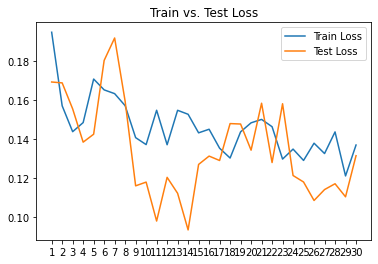

In [18]:
plt.plot([i for i in range(1,epoch_n+1)], train_loss, label='Train Loss')
plt.plot([i for i in range(1,epoch_n+1)], test_loss, label='Test Loss')
plt.legend()
plt.title("Train vs. Test Loss")
plt.xticks(np.arange(1, epoch_n+1, 1))

#Testing and Visualization

In [21]:
model.eval()


output_masks = []
output_labels = []

with torch.no_grad():
  for i in range(testset.__len__()):
    image, labels = testset.__getitem__(i)

    input_image = image.unsqueeze(0).to(device)
    
    labels = labels.squeeze(0)
    
    pred = model(input_image)

    output_mask = torch.max(pred, dim = 1)[1].cpu().squeeze(0).numpy()

    crop_x = (labels.shape[0] - output_mask.shape[0]) // 2
    crop_y = (labels.shape[1] - output_mask.shape[1]) // 2
    labels = labels[crop_x: labels.shape[0] - crop_x, crop_y: labels.shape[1] - crop_y].numpy()
    
    output_masks.append(output_mask)
    output_labels.append(labels)

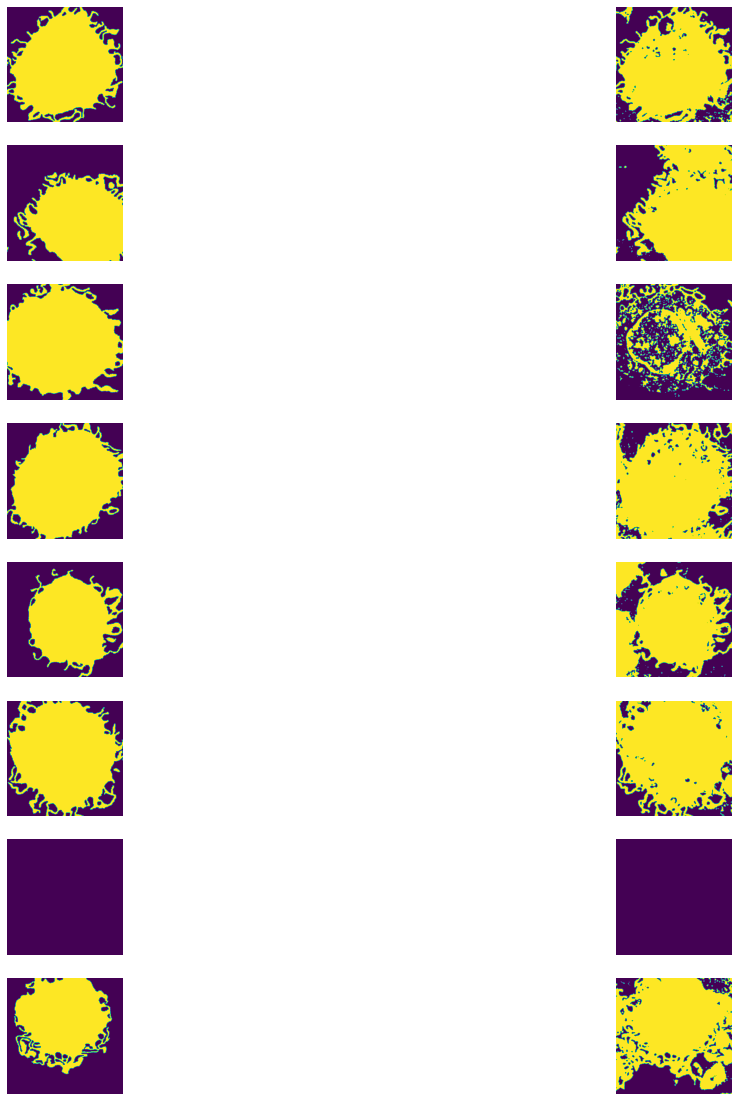

In [22]:
fig, axes = plt.subplots(testset.__len__(), 2, figsize = (20, 20))

for i in range(testset.__len__()):
  axes[i, 0].imshow(output_labels[i])
  axes[i, 0].axis('off')
  axes[i, 1].imshow(output_masks[i])
  axes[i, 1].axis('off')

In [ ]:
!nvidia-smi